## Data Exploration for Character Prediction
Goal: Given a movie and a dialogue predict which character is mostly like to say that particular line

Goal: Gradio + Start Deployment and this would be one of the features on the app + Add in the sentiment where you can predict the sentiment

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv("../sentiment_analysis/lines_cleaned.csv")
character_lines_df = data.rename(columns={'count': 'num_lines_per_movie_count'})
character_lines_df.shape

(200369, 6)

(array([23916., 19689., 18407., 18438., 19008., 13626., 17035., 14318.,
         4511.,  5535.,  9062.,  8589.,  3641.,   944.,  3876.,  7046.,
         2092.,  3218.,  1121.,  2301.,  1197.,     0.,  1269.,     0.,
            0.,     0.,     0.,     0.,     0.,  1530.]),
 array([ 451.        ,  486.96666667,  522.93333333,  558.9       ,
         594.86666667,  630.83333333,  666.8       ,  702.76666667,
         738.73333333,  774.7       ,  810.66666667,  846.63333333,
         882.6       ,  918.56666667,  954.53333333,  990.5       ,
        1026.46666667, 1062.43333333, 1098.4       , 1134.36666667,
        1170.33333333, 1206.3       , 1242.26666667, 1278.23333333,
        1314.2       , 1350.16666667, 1386.13333333, 1422.1       ,
        1458.06666667, 1494.03333333, 1530.        ]),
 <BarContainer object of 30 artists>)

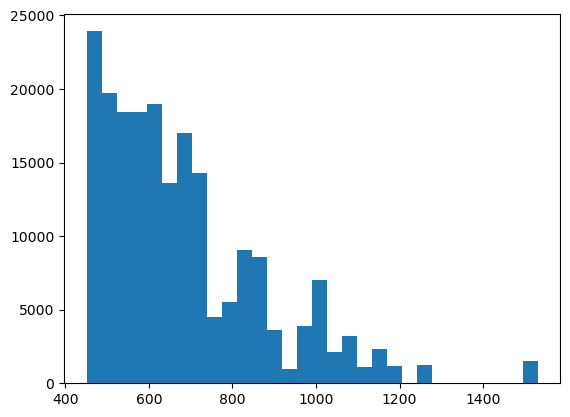

In [4]:
plt.hist(character_lines_df["num_lines_per_movie_count"], bins = 30)

In [5]:
movie_count = len(character_lines_df["movieID"].unique())
print(f"The number of movies there are is {movie_count} ")

The number of movies there are is 314 


In [6]:
columns = ["movieID", "movieTitle", "movie_year", "IMDB_Rating", "num_IMDB_votes", "genres"]
movie_data_df = pd.read_csv("../data/movie_titles_metadata.tsv", sep="\t", on_bad_lines='skip', names= columns)
movie_data_df.shape

(617, 6)

Keeps the movie_data rows that is already in the character_lines_df. This way we can merge them together. Character_lines_df already ensures there is enough lines per movie to work with

In [7]:
movie_data_df = movie_data_df[movie_data_df["movieID"].isin(character_lines_df["movieID"])]
movie_data_df.shape

(313, 6)

In [8]:
#now merge the two dataframes on movieID
character_lines_df = pd.merge(movie_data_df, character_lines_df, on="movieID")
character_lines_df = character_lines_df.drop(columns=["movie_year", "IMDB_Rating", "num_IMDB_votes", "genres"])

In [9]:
character_count_per_movie = character_lines_df.groupby("movieID")["character"].nunique()
character_count_per_movie.describe()

count    313.000000
mean      16.817891
std        5.657596
min        5.000000
25%       13.000000
50%       16.000000
75%       19.000000
max       44.000000
Name: character, dtype: float64

Remove movies in which the character count is less than 7

In [10]:
character_count_valid_ids = character_count_per_movie[character_count_per_movie >= 5].index
character_lines_df = character_lines_df[character_lines_df["movieID"].isin(character_count_valid_ids)]

Now, we want to make sure that each character has enough lines. Each character must have at least 50 lines to work with.

In [11]:
character_lines_per_movie = character_lines_df.groupby(["movieID", "characterID"])["text"].count().reset_index(name="num_lines_per_character")
character_lines_per_movie_valid = character_lines_per_movie[character_lines_per_movie["num_lines_per_character"] >= 50]["characterID"]
character_lines_df = character_lines_df[character_lines_df["characterID"].isin(character_lines_per_movie_valid)]
character_lines_df


,movieID,movieTitle,lineID,characterID,character,text,num_lines_per_movie_count
0,m0,10 things i hate about you,L1045,u0,BIANCA,They do not!,654
1,m0,10 things i hate about you,L1044,u2,CAMERON,They do to!,654
2,m0,10 things i hate about you,L985,u0,BIANCA,I hope so.,654
3,m0,10 things i hate about you,L984,u2,CAMERON,She okay?,654
4,m0,10 things i hate about you,L925,u0,BIANCA,Let's go.,654
...,...,...,...,...,...,...,...
199883,m615,young frankenstein,L665696,u9019,IGOR,Whew! A nineteen-inch drill.,574
199884,m615,young frankenstein,L665695,u9020,INGA,His schwanzstucker.,574
199885,m615,young frankenstein,L665694,u9019,IGOR,His what??,574
199886,m615,young frankenstein,L665652,u9020,INGA,There must have been someone else down here then.,574


In [12]:
#side quest --- how many character in 10 things i hate about you?
character_count = character_lines_df[character_lines_df["movieID"] == "m0"]["characterID"].nunique()
print(f"Number of characters in movie m0: {character_count}")


Number of characters in movie m0: 5


After removing the characters with less than 50 lines, once again remove the movies with less than 5 predictable characters

In [13]:
character_count_per_movie = character_lines_df.groupby("movieID")["character"].nunique()
character_count_per_movie

movieID
m0      5
m10     2
m100    3
m101    2
m102    2
       ..
m88     3
m89     4
m90     5
m92     5
m94     3
Name: character, Length: 313, dtype: int64

In [14]:
character_count_per_movie.describe()

count    313.000000
mean       3.354633
std        1.103078
min        1.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        7.000000
Name: character, dtype: float64

In [15]:
valid_movies_character_lines = character_count_per_movie[character_count_per_movie >= 5].index
print(valid_movies_character_lines)
print(len(valid_movies_character_lines))

Index(['m0', 'm105', 'm124', 'm139', 'm149', 'm152', 'm162', 'm165', 'm18',
       'm190', 'm203', 'm217', 'm235', 'm238', 'm267', 'm293', 'm322', 'm334',
       'm35', 'm368', 'm373', 'm380', 'm405', 'm42', 'm428', 'm435', 'm444',
       'm467', 'm475', 'm495', 'm507', 'm513', 'm516', 'm528', 'm532', 'm533',
       'm536', 'm537', 'm569', 'm575', 'm59', 'm595', 'm606', 'm78', 'm82',
       'm90', 'm92'],
      dtype='object', name='movieID')
47


In [16]:
character_lines_df = character_lines_df[character_lines_df["movieID"].isin(valid_movies_character_lines)]

In [17]:
character_lines_df.drop(columns="num_lines_per_movie_count", inplace = True)
character_lines_df

/var/folders/f4/_5js21356_g8zx61755lqs1m0000gn/T/ipykernel_21409/2441820773.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  character_lines_df.drop(columns="num_lines_per_movie_count", inplace = True)


,movieID,movieTitle,lineID,characterID,character,text
0,m0,10 things i hate about you,L1045,u0,BIANCA,They do not!
1,m0,10 things i hate about you,L1044,u2,CAMERON,They do to!
2,m0,10 things i hate about you,L985,u0,BIANCA,I hope so.
3,m0,10 things i hate about you,L984,u2,CAMERON,She okay?
4,m0,10 things i hate about you,L925,u0,BIANCA,Let's go.
...,...,...,...,...,...,...
198716,m606,wild things,L654730,u8916,SAM,Swamp's where it's at Sandy. Gives you a look...
198718,m606,wild things,L654728,u8916,SAM,Sorry Sandy. I've got plans.
198720,m606,wild things,L654726,u8916,SAM,I can't Sandy. I've got to run.
198721,m606,wild things,L654724,u8916,SAM,Can't. Got a passenger.


In [18]:
character_lines_df.to_csv("character_lines.csv")

Now create a new dataframe with movieID, characters, characterID, lines spoken by each character, and the total number of characters in that movie that we can predict from

In [19]:
line_count_df = character_lines_df.groupby(["movieID", "characterID", "character"])["text"].count().reset_index(name="character_line_count")
line_count_df.to_csv("character_line_count.csv")